# Analysis on Heart Failure 

In [437]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant

In [438]:
# Load the Heart Failure Clinical Records Dataset
data_path = '../data/external/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_path, low_memory=False)
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [439]:
print("Initial Data Information:")
data.info()

Initial Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 

In [440]:
print("\nSummary Statistics:\n", data.describe())


Summary Statistics:
               age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.

In [441]:
print("\nMissing Values Per Column:\n", data.isna().sum())


Missing Values Per Column:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


#### Preprocessing and Missing Data Handling
We will preprocess the dataset by applying various strategies to handle missing and erroneous data.

In [442]:
# Handling Missing and Erroneous Data
# Introduce null and negative values for testing purposes
numeric_cols = data.select_dtypes(include='number').columns
for col in numeric_cols:
    data.loc[np.random.choice(data.index, size=5, replace=False), col] = np.nan
    data.loc[np.random.choice(data.index, size=3, replace=False), col] = -np.abs(data[col].dropna())

# Fill missing values with median and replace negative values with NaN
data[numeric_cols] = data[numeric_cols].apply(lambda x: np.where(x < 0, np.nan, x))
data[numeric_cols] = data[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Adding a total column for aggregation
data['Total'] = data[numeric_cols].sum(axis=1)

# Display cleaned data
print("\nCleaned Data Head:")
print(data.head())


Cleaned Data Head:
    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  60.0      0.0                     582.0       0.0               20.0   
1  55.0      0.0                     248.0       0.0               38.0   
2  65.0      0.0                     146.0       0.0               20.0   
3  50.0      1.0                     111.0       0.0               20.0   
4  65.0      1.0                     160.0       1.0               20.0   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                  1.0  265000.00               1.9         130.0  1.0   
1                  0.0  263358.03               1.1         136.0  1.0   
2                  0.0  162000.00               1.3         129.0  1.0   
3                  0.0  210000.00               1.9         137.0  1.0   
4                  0.0  327000.00               2.7         116.0  0.0   

   smoking  time  DEATH_EVENT      Total  
0      0.0   4.0          1.0  265800.90 

#### Exploratory Data Analysis (EDA)
EDA focuses on understanding the data distribution, feature relationships, and trends. Visualizations will include histograms, scatter plots, and correlation heatmaps.

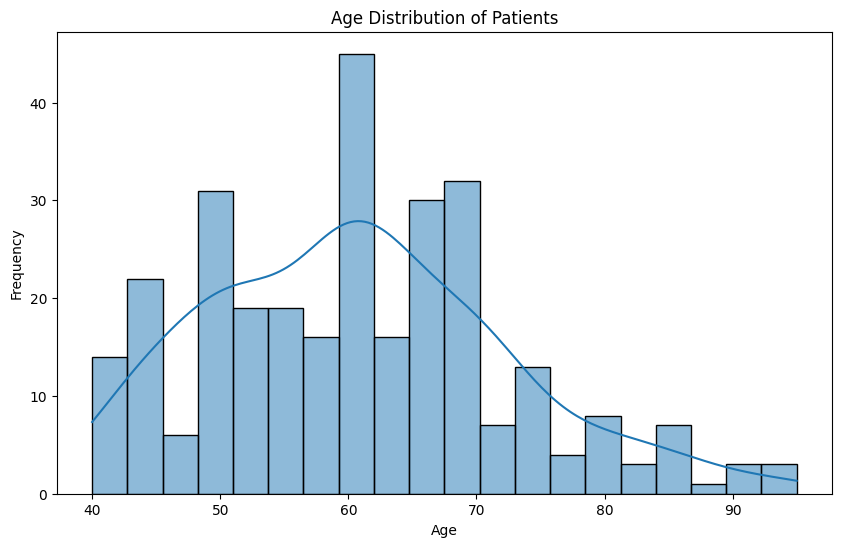

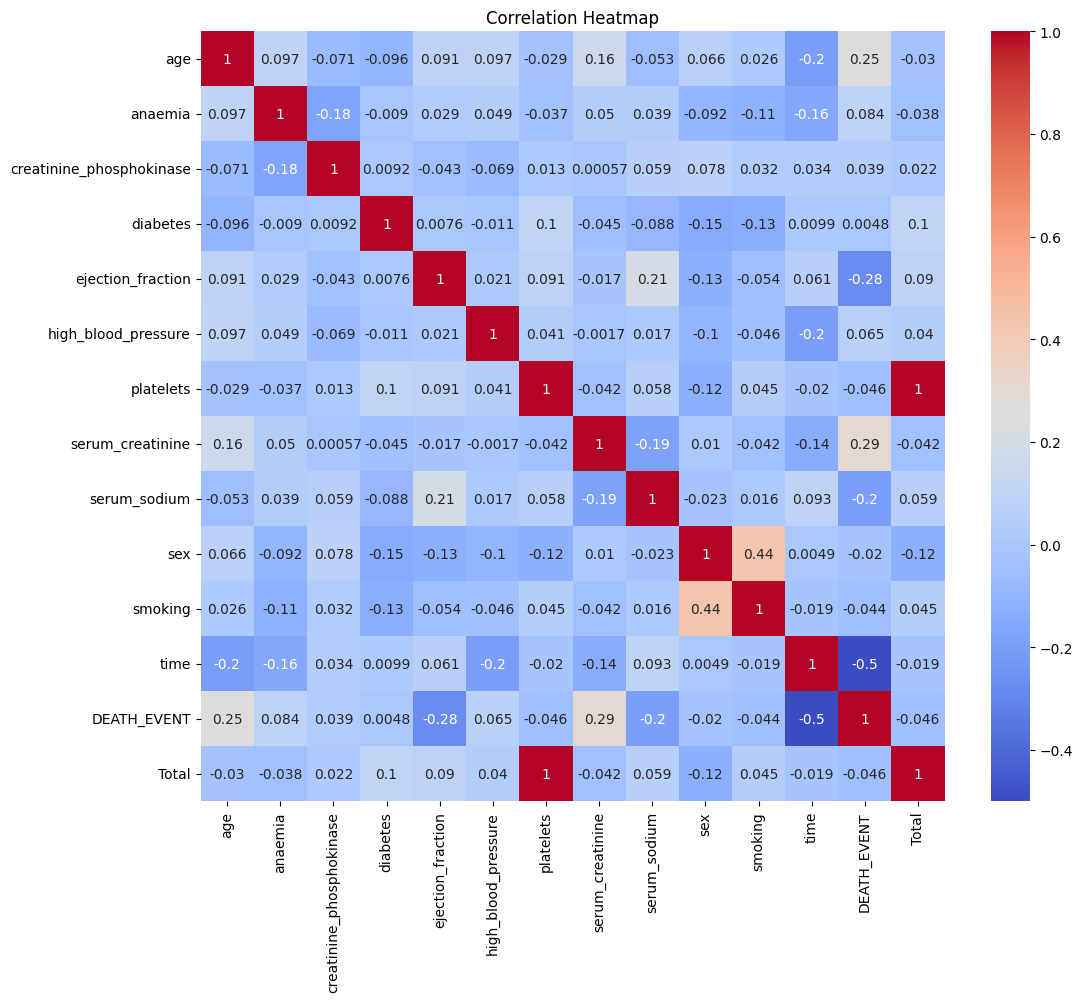

In [443]:
# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=20, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Clustering and PCA
We will cluster the data using KMeans, Agglomerative Clustering, and DBSCAN after applying PCA for dimensionality reduction.

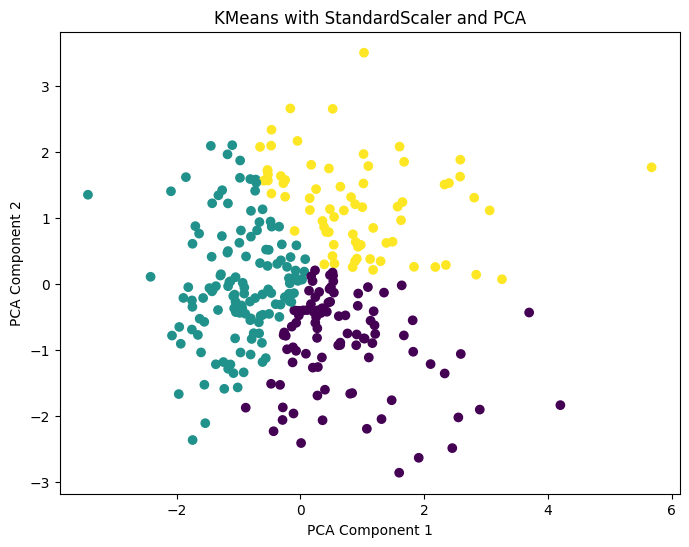

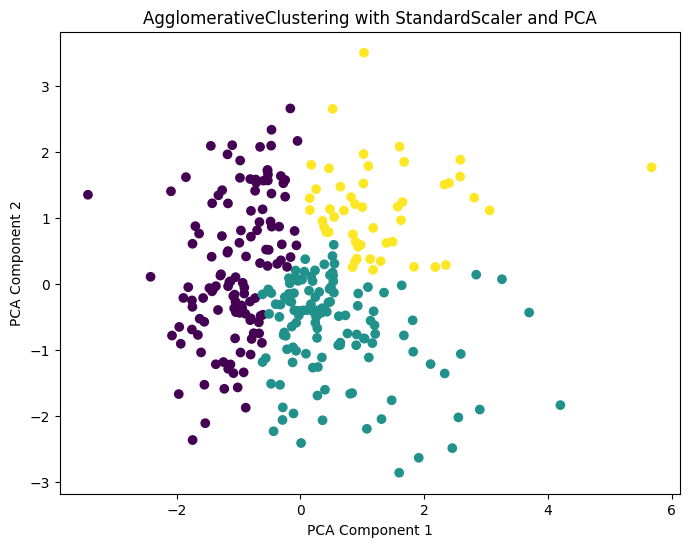

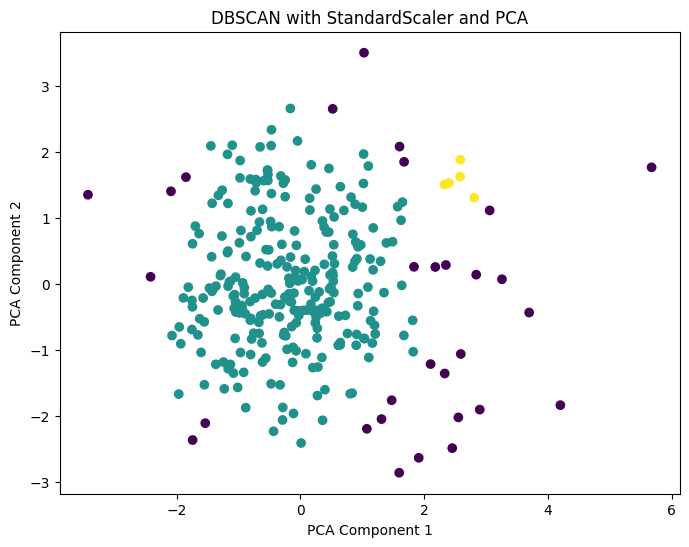

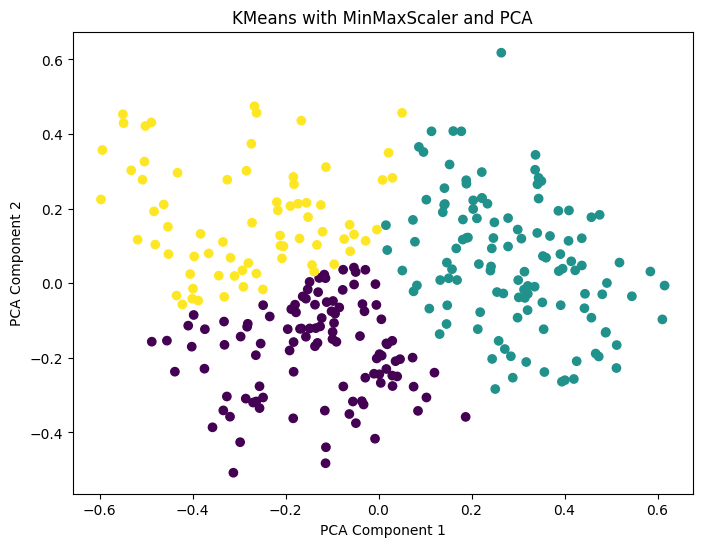

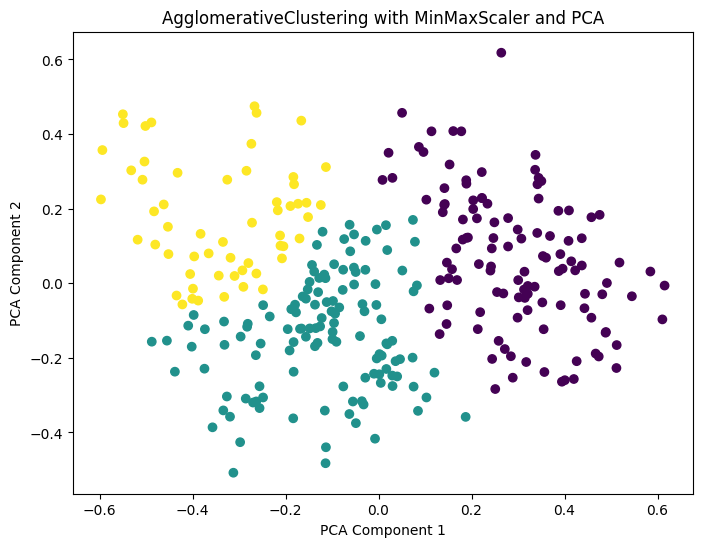

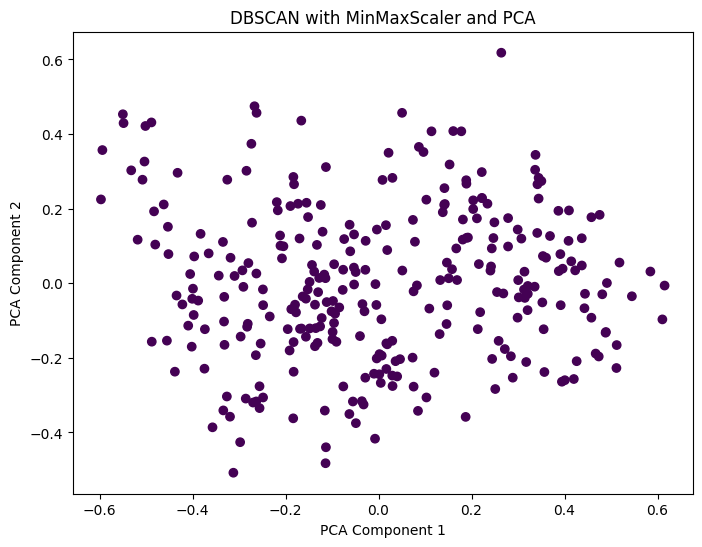

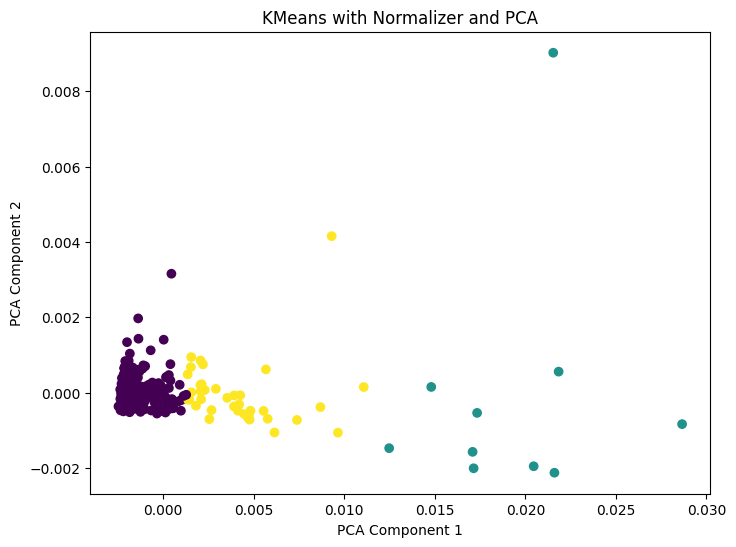

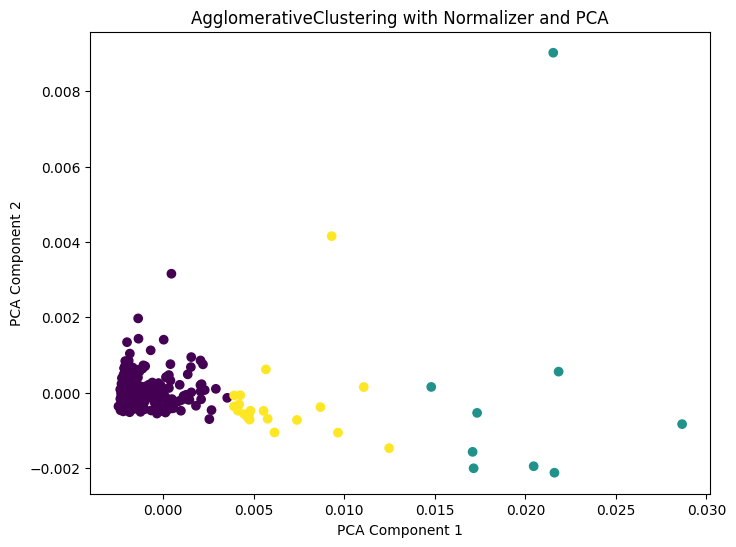

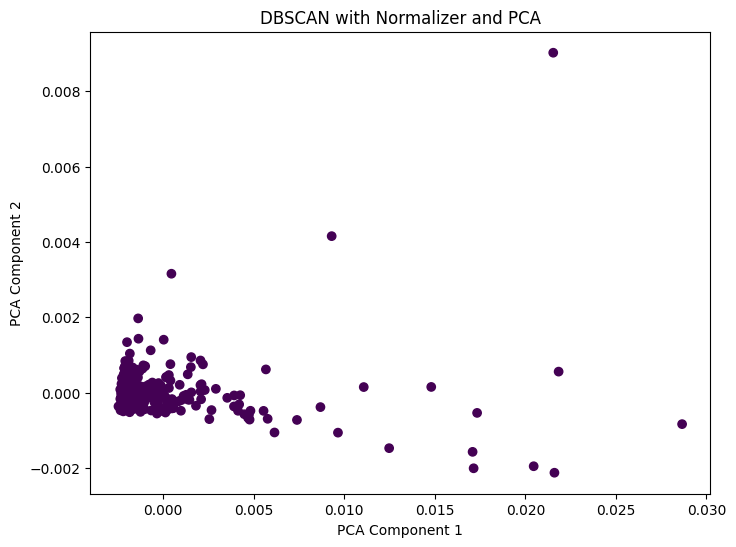

In [444]:
# Selecting Features for Clustering
features = data[['age', 'creatinine_phosphokinase', 'ejection_fraction', 
                 'platelets', 'serum_creatinine', 'serum_sodium', 'time']]

# Apply Scaling and PCA
scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler(), 'Normalizer': Normalizer()}
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=3),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}

for scaler_name, scaler in scalers.items():
    scaled_features = scaler.fit_transform(features)
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(scaled_features)

    for algo_name, algorithm in clustering_algorithms.items():
        labels = algorithm.fit_predict(pca_features)
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', marker='o')
        plt.title(f"{algo_name} with {scaler_name} and PCA")
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()


#### Regression and Cross-Validation
We evaluate multiple regression models (Linear, Lasso, Ridge, ElasticNet) on different datasets.

In [445]:
# Regression Models and Cross-Validation
datasets = {
    'Full': data.drop(columns=['DEATH_EVENT']), 
    'Biochemical': data[['serum_creatinine', 'serum_sodium', 'ejection_fraction', 'platelets', 'time']],
    'Lifestyle': data[['age', 'sex', 'smoking', 'diabetes', 'time']],
    'Medical': data[['age', 'anaemia', 'diabetes', 'high_blood_pressure', 'ejection_fraction']]
}

# Standardize datasets before training
datasets_standardized = {}
scaler = StandardScaler()
for name, dataset in datasets.items():
    datasets_standardized[name] = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

# Update model hyperparameters to address convergence issues
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1, max_iter=10000),
    'Ridge': Ridge(alpha=1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
}

for model_name, model in models.items():
    for dataset_name, dataset in datasets_standardized.items():
        X = dataset
        y = data['DEATH_EVENT']
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
        print(f"{model_name} on {dataset_name}: RMSE = {-scores.mean():.3f}")

Linear Regression on Full: RMSE = 0.000
Linear Regression on Biochemical: RMSE = 0.378
Linear Regression on Lifestyle: RMSE = 0.403
Linear Regression on Medical: RMSE = 0.438
Lasso on Full: RMSE = 0.411
Lasso on Biochemical: RMSE = 0.411
Lasso on Lifestyle: RMSE = 0.418
Lasso on Medical: RMSE = 0.459
Ridge on Full: RMSE = 0.379
Ridge on Biochemical: RMSE = 0.378
Ridge on Lifestyle: RMSE = 0.403
Ridge on Medical: RMSE = 0.438
ElasticNet on Full: RMSE = 0.388
ElasticNet on Biochemical: RMSE = 0.388
ElasticNet on Lifestyle: RMSE = 0.408
ElasticNet on Medical: RMSE = 0.445


#### Feature Importance
Visualizing coefficients to compare feature importance across models.

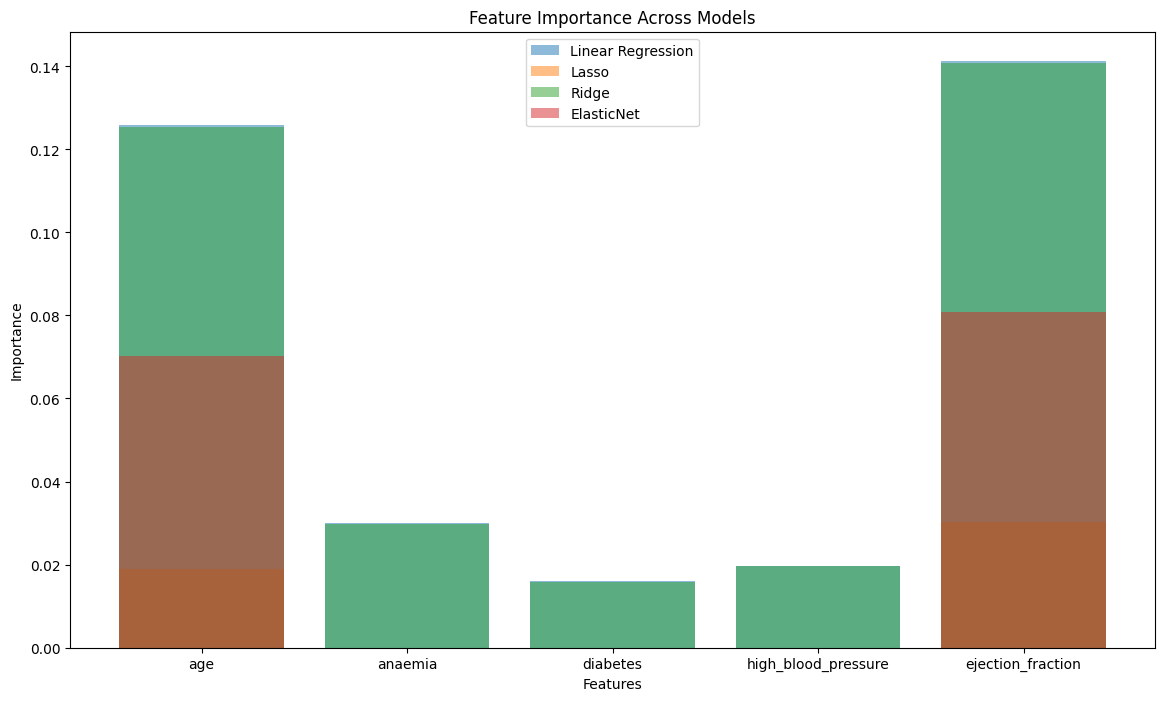

In [446]:
# Feature Importance
plt.figure(figsize=(14, 8))
for model_name, model in models.items():
    model.fit(X, y)
    importance = np.abs(model.coef_)
    plt.bar(X.columns, importance, alpha=0.5, label=model_name)

plt.title('Feature Importance Across Models')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.show()